# Santa's Workshop: Multiproduct Process Simulations and State-Task Networks

#### Kaleigh Ellis and Gina Pernesky

CBE40455 Process Operations Final Project  
December 14, 2017

## Introduction

Santa is looking for help to optimize the productivity of his elves this Christmas season. One particular team of elves manufactures wooden toy cars, boats, and trains which are painted with red, blue, and yellow paint, as shown below.

<img src = "Products.png">

These toys are valued based on their "child-happiness value," which is the metric Santa uses to judge how a child will enjoy playing with a toy. Factors that influence this decision is the toy's appearance and how long the child will play with the toy. Santa has valued these specific toys with child-happiness values of 10, 12, and 15 for the car, boat, and train, respectively. 

Below is a the flow chart for the toy production.

<img src = "flowchart.PNG">

### Production Criteria

Each production shift last 4 hours.

The only restriction on the raw materials is the lumber. There are 200 oz of wood available per shift. All other materials (red, blue and yellow paint and wrapping paper) are unlimited.

The current job assignments are:
- a group of elves on one planer station of milling lumber. In 20 minutes they can mill 50 pieces of wood, each weighing 1 oz. 
- two elves assembling toys. They can either make a car, a boat, or a train. Production times are listed in the table, below.
- two elves painting toys. The cars are painted red, the boats are painted blue and then red, and the trains are first painted yellow, then blue, and lastly red. 
- one elf assigned to wrapping the presents. She can wrap any toy she wants, and the toys cannot be wrapped until they are painted. 

Santa wants at least one of each toy produced per shift. Remaining materials and labor must be used to maximize the child-happiness value.



<img src = "Screen Shot 2017-12-10 at 4.43.52 PM.png">

### Objectives

Santa has two extra elves, and he wants to know where he should assign them to have the most productivity and the greatest increase in child happiness.


In our model, we will first solve for the child-happiness value and the amount of toys produced under the current job assignments. Then we will add one elf to assembly, then one elf to painting, and finally one elf to wrapping to see where there is a greatest improvement to efficiency and child-happiness value. Lastly, we will model the two extra elves scenario and place the two elves where they will add the most productivity to this North Pole operation.

## Build a Pyomo Model
#### These are the current elf assignments.

### State Task Network Data

In [1]:
H = 240   # total minutes available, 4 hour shift 

Process = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Lumber'           : {'capacity': 200,  'initial': 200, 'value': 0},
        'Pieces'           : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Car'          : {'capacity': 20,   'initial':   0, 'value': 0},
        'Raw Boat'         : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Train'        : {'capacity': 80,   'initial':   0, 'value': 0},
        'Blue Boat'        : {'capacity': 50,   'initial':   0, 'value': 0},
        'Yellow Train'     : {'capacity': 80,   'initial':   0, 'value': 0},
        'Yellow Blue Train': {'capacity': 80,   'initial':   0, 'value': 0},
        'Painted Car'      : {'capacity': 20,   'initial':   0, 'value': 0},
        'Painted Boat'     : {'capacity': 50,   'initial':   0, 'value': 0},
        'Painted Train'    : {'capacity': 80,   'initial':   0, 'value': 0},
        'Wrapped Car'      : {'capacity': 40,   'initial':   0, 'value': 10},
        'Wrapped Boat'     : {'capacity': 100,   'initial':  0, 'value': 12},
        'Wrapped Train'    : {'capacity': 160,   'initial':  0, 'value': 15},     
    },
    'ST_ARCS': {
        ('Lumber',            'Milling')                : {'rho': 1.0},
        ('Pieces',            'Car Assembly')           : {'rho': 1.0},
        ('Pieces',            'Boat Assembly')          : {'rho': 1.0},
        ('Pieces',            'Train Assembly')         : {'rho': 1.0},
        ('Raw Car',           'Red Car Painting')       : {'rho': 1.0},
        ('Raw Boat',          'Blue Boat Painting')     : {'rho': 1.0},
        ('Blue Boat',         'Red Boat Painting')      : {'rho': 1.0},
        ('Raw Train',         'Yellow Train Painting')  : {'rho': 1.0},
        ('Yellow Train',      'Blue Train Painting')    : {'rho': 1.0},
        ('Yellow Blue Train', 'Red Train Painting')     : {'rho': 1.0},
        ('Painted Car',       'Car Wrapping')           : {'rho': 1.0},
        ('Painted Boat',      'Boat Wrapping')          : {'rho': 1.0},
        ('Painted Train',     'Train Wrapping')         : {'rho': 1.0},
    },
    'TS_ARCS': {
        ('Milling',               'Pieces')            : {'dur': 20, 'rho': 1.0},
        ('Car Assembly',          'Raw Car')           : {'dur': 5,  'rho': 1.0},
        ('Boat Assembly',         'Raw Boat')          : {'dur': 10, 'rho': 1.0},
        ('Train Assembly',        'Raw Train')         : {'dur': 15, 'rho': 1.0},
        ('Red Car Painting',      'Painted Car')       : {'dur': 10, 'rho': 1.0},
        ('Red Boat Painting',     'Painted Boat')      : {'dur': 15, 'rho': 1.0},
        ('Red Train Painting',    'Painted Train')     : {'dur': 20, 'rho': 1.0},
        ('Blue Boat Painting',    'Blue Boat')         : {'dur': 5,  'rho': 1.0},
        ('Blue Train Painting',   'Yellow Blue Train') : {'dur': 15, 'rho': 1.0},
        ('Yellow Train Painting', 'Yellow Train')      : {'dur': 5,  'rho': 1.0},
        ('Car Wrapping',          'Wrapped Car')       : {'dur': 5,  'rho': 1.0},
        ('Boat Wrapping',         'Wrapped Boat')      : {'dur': 15, 'rho': 1.0},
        ('Train Wrapping',        'Wrapped Train')     : {'dur': 20, 'rho': 1.0},
    },
    'UNIT_TASKS': {
        ('Planer', 'Milling') : {'Bmin': 0, 'Bmax': 50, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Assembler 1', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
         
        ('Assembler 2', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 1', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 2', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Wrapper', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

### Characterization of Tasks

In [2]:
STN = Process

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [3]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

### Characterization of States

In [4]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s

### Characterization of Units

In [5]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [6]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['value']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
# additional production constraints (must produce one of each toy per shift)     
model.cons.add(model.S['Wrapped Car',H] >= 4)
model.cons.add(model.S['Wrapped Boat',H] >= 10)
model.cons.add(model.S['Wrapped Train',H] >= 16)

SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2160.0
  Upper bound: 2160.0
  Number of objectives: 1
  Number of constraints: 20256
  Number of variables: 15427
  Number of nonzeros: 115579
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 723
      Number of created subproblems: 723
  Error rc: 0
  Time: 66.65642809867859
# ----------------------------------------------------------
#   Solution Information
# --------------------

## State Inventories

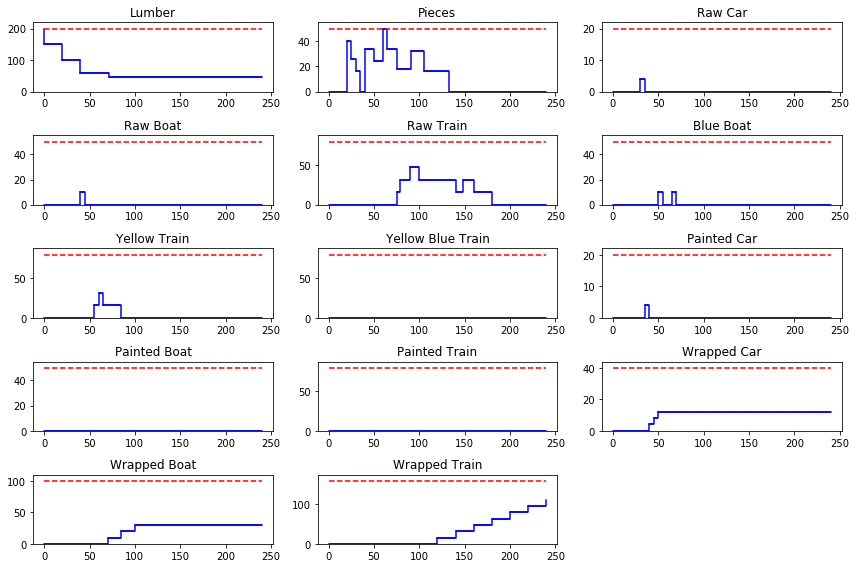

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

## Gant Chart

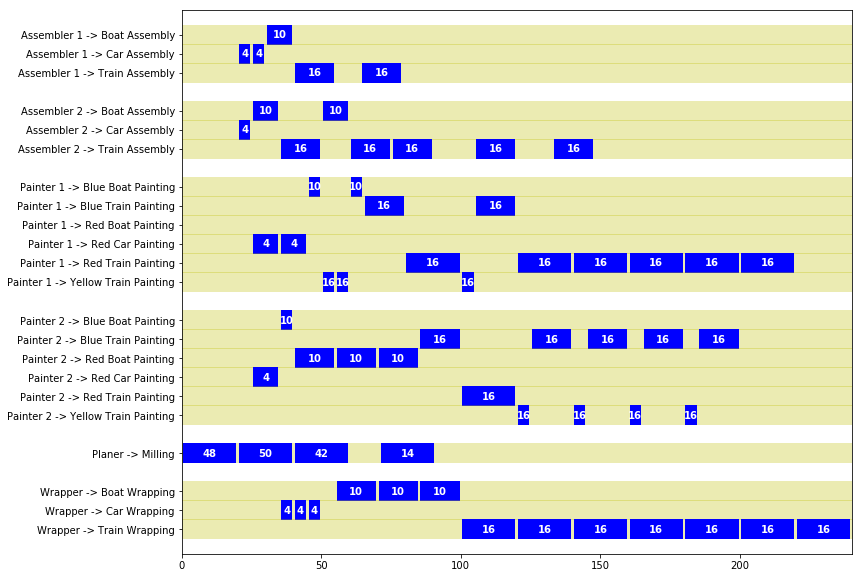

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.0f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

In [9]:
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} oz".format(s,model.S[s,H]()))
print(" ")        
print("Child Happiness Value = {0:12.0f}".format(model.Value()))

Final Conditions
    Final Inventories:
        Lumber        46.0 oz
        Pieces         0.0 oz
        Raw Car        0.0 oz
        Raw Boat       0.0 oz
        Raw Train      0.0 oz
        Blue Boat      0.0 oz
        Yellow Train     0.0 oz
        Yellow Blue Train     0.0 oz
        Painted Car     0.0 oz
        Painted Boat     0.0 oz
        Painted Train     0.0 oz
        Wrapped Car    12.0 oz
        Wrapped Boat    30.0 oz
        Wrapped Train   112.0 oz
 
Child Happiness Value =         2160


Therefore, under this initial assignment of elves, the total happiness value is 2160, with 3 cars, 3 boats, and 7 trains produced.

### Assignment of First Elf

#### Assigment as Third Assembly Elf

In [91]:
H = 240   # total minutes available, 4 hour shift 

Process2 = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Lumber'           : {'capacity': 200,  'initial': 200, 'value': 0},
        'Pieces'           : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Car'          : {'capacity': 20,   'initial':   0, 'value': 0},
        'Raw Boat'         : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Train'        : {'capacity': 80,   'initial':   0, 'value': 0},
        'Blue Boat'        : {'capacity': 50,   'initial':   0, 'value': 0},
        'Yellow Train'     : {'capacity': 80,   'initial':   0, 'value': 0},
        'Yellow Blue Train': {'capacity': 80,   'initial':   0, 'value': 0},
        'Painted Car'      : {'capacity': 20,   'initial':   0, 'value': 0},
        'Painted Boat'     : {'capacity': 50,   'initial':   0, 'value': 0},
        'Painted Train'    : {'capacity': 80,   'initial':   0, 'value': 0},
        'Wrapped Car'      : {'capacity': 28,   'initial':   0, 'value': 10},
        'Wrapped Boat'     : {'capacity': 70,   'initial':  0, 'value': 12},
        'Wrapped Train'    : {'capacity': 112,   'initial':  0, 'value': 15},     
    },
    'ST_ARCS': {
        ('Lumber',            'Milling')                : {'rho': 1.0},
        ('Pieces',            'Car Assembly')           : {'rho': 1.0},
        ('Pieces',            'Boat Assembly')          : {'rho': 1.0},
        ('Pieces',            'Train Assembly')         : {'rho': 1.0},
        ('Raw Car',           'Red Car Painting')       : {'rho': 1.0},
        ('Raw Boat',          'Blue Boat Painting')     : {'rho': 1.0},
        ('Blue Boat',         'Red Boat Painting')      : {'rho': 1.0},
        ('Raw Train',         'Yellow Train Painting')  : {'rho': 1.0},
        ('Yellow Train',      'Blue Train Painting')    : {'rho': 1.0},
        ('Yellow Blue Train', 'Red Train Painting')     : {'rho': 1.0},
        ('Painted Car',       'Car Wrapping')           : {'rho': 1.0},
        ('Painted Boat',      'Boat Wrapping')          : {'rho': 1.0},
        ('Painted Train',     'Train Wrapping')         : {'rho': 1.0},
    },
    'TS_ARCS': {
        ('Milling',               'Pieces')            : {'dur': 20, 'rho': 1.0},
        ('Car Assembly',          'Raw Car')           : {'dur': 5,  'rho': 1.0},
        ('Boat Assembly',         'Raw Boat')          : {'dur': 10, 'rho': 1.0},
        ('Train Assembly',        'Raw Train')         : {'dur': 15, 'rho': 1.0},
        ('Red Car Painting',      'Painted Car')       : {'dur': 10, 'rho': 1.0},
        ('Red Boat Painting',     'Painted Boat')      : {'dur': 15, 'rho': 1.0},
        ('Red Train Painting',    'Painted Train')     : {'dur': 20, 'rho': 1.0},
        ('Blue Boat Painting',    'Blue Boat')         : {'dur': 5,  'rho': 1.0},
        ('Blue Train Painting',   'Yellow Blue Train') : {'dur': 15, 'rho': 1.0},
        ('Yellow Train Painting', 'Yellow Train')      : {'dur': 5,  'rho': 1.0},
        ('Car Wrapping',          'Wrapped Car')       : {'dur': 5,  'rho': 1.0},
        ('Boat Wrapping',         'Wrapped Boat')      : {'dur': 15, 'rho': 1.0},
        ('Train Wrapping',        'Wrapped Train')     : {'dur': 20, 'rho': 1.0},
    },
    'UNIT_TASKS': {
        ('Planer', 'Milling') : {'Bmin': 0, 'Bmax': 50, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Assembler 1', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
         
        ('Assembler 2', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Assembler 3', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 3', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 3', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 1', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 2', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Wrapper', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

### Characterization of Tasks

In [92]:
STN = Process2

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [93]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

### Characterization of States

In [94]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s

### Characterization of Units

In [95]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [96]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['value']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
# additional production constraints (must produce one of each toy per shift)     
model.cons.add(model.S['Wrapped Car',H] >= 4)
model.cons.add(model.S['Wrapped Boat',H] >= 10)
model.cons.add(model.S['Wrapped Train',H] >= 16)

SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2160.0
  Upper bound: 2160.0
  Number of objectives: 1
  Number of constraints: 22185
  Number of variables: 17114
  Number of nonzeros: 128855
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 769
      Number of created subproblems: 769
  Error rc: 0
  Time: 65.03101706504822
# ----------------------------------------------------------
#   Solution Information
# --------------------

### State Inventories

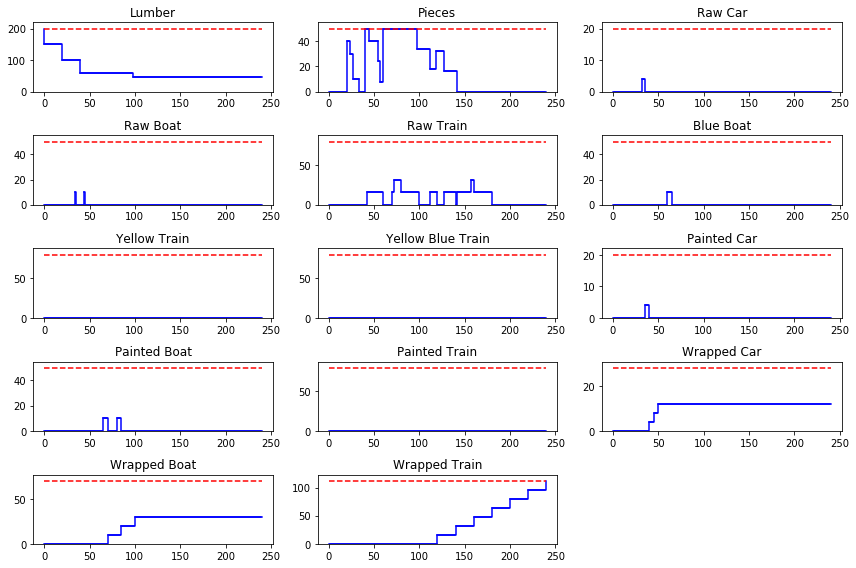

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

### Gant Chart

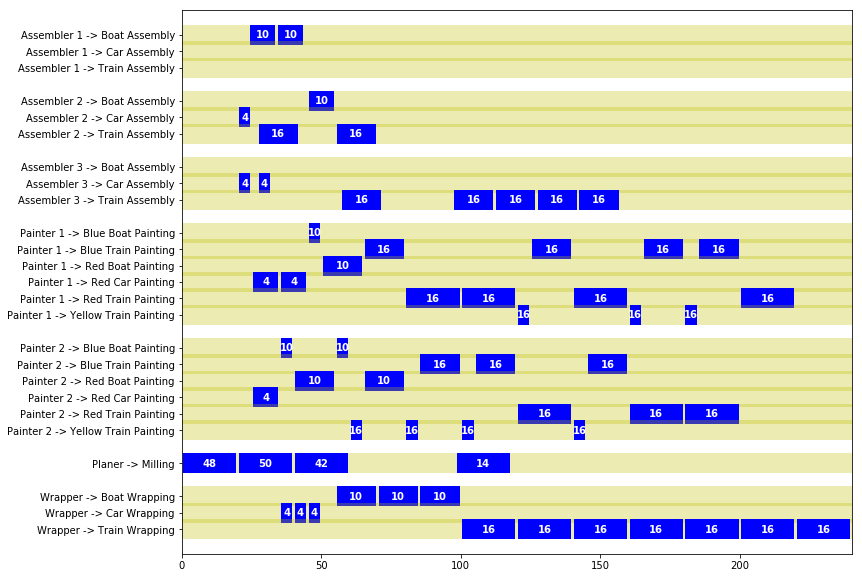

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.0f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

In [99]:
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} oz".format(s,model.S[s,H]()))
print(" ")        
print("Child Happiness Value = {0:12.0f}".format(model.Value()))

Final Conditions
    Final Inventories:
        Lumber        46.0 oz
        Pieces        -0.0 oz
        Raw Car        0.0 oz
        Raw Boat       0.0 oz
        Raw Train      0.0 oz
        Blue Boat     -0.0 oz
        Yellow Train     0.0 oz
        Yellow Blue Train     0.0 oz
        Painted Car     0.0 oz
        Painted Boat     0.0 oz
        Painted Train     0.0 oz
        Wrapped Car    12.0 oz
        Wrapped Boat    30.0 oz
        Wrapped Train   112.0 oz
 
Child Happiness Value =         2160


With an extra assembler elf, the total happiness value says the same at 2160, with 3 cars, 3 boats, and 7 trains produced. Therefore, the limiting task of this toy manufacturing line is not the assembling step, and Santa should place an extra elf at a different job.

### Assignment of First Elf

#### Assigment as Third Painter Elf

In [100]:
H = 240   # total minutes available, 4 hour shift 

Process = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Lumber'           : {'capacity': 200,  'initial': 200, 'value': 0},
        'Pieces'           : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Car'          : {'capacity': 20,   'initial':   0, 'value': 0},
        'Raw Boat'         : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Train'        : {'capacity': 80,   'initial':   0, 'value': 0},
        'Blue Boat'        : {'capacity': 50,   'initial':   0, 'value': 0},
        'Yellow Train'     : {'capacity': 80,   'initial':   0, 'value': 0},
        'Yellow Blue Train': {'capacity': 80,   'initial':   0, 'value': 0},
        'Painted Car'      : {'capacity': 20,   'initial':   0, 'value': 0},
        'Painted Boat'     : {'capacity': 50,   'initial':   0, 'value': 0},
        'Painted Train'    : {'capacity': 80,   'initial':   0, 'value': 0},
        'Wrapped Car'      : {'capacity': 32,   'initial':   0, 'value': 10},
        'Wrapped Boat'     : {'capacity': 80,   'initial':  0, 'value': 12},
        'Wrapped Train'    : {'capacity': 112,   'initial':  0, 'value': 15},      
    },
    'ST_ARCS': {
        ('Lumber',            'Milling')                : {'rho': 1.0},
        ('Pieces',            'Car Assembly')           : {'rho': 1.0},
        ('Pieces',            'Boat Assembly')          : {'rho': 1.0},
        ('Pieces',            'Train Assembly')         : {'rho': 1.0},
        ('Raw Car',           'Red Car Painting')       : {'rho': 1.0},
        ('Raw Boat',          'Blue Boat Painting')     : {'rho': 1.0},
        ('Blue Boat',         'Red Boat Painting')      : {'rho': 1.0},
        ('Raw Train',         'Yellow Train Painting')  : {'rho': 1.0},
        ('Yellow Train',      'Blue Train Painting')    : {'rho': 1.0},
        ('Yellow Blue Train', 'Red Train Painting')     : {'rho': 1.0},
        ('Painted Car',       'Car Wrapping')           : {'rho': 1.0},
        ('Painted Boat',      'Boat Wrapping')          : {'rho': 1.0},
        ('Painted Train',     'Train Wrapping')         : {'rho': 1.0},
    },
    'TS_ARCS': {
        ('Milling',               'Pieces')            : {'dur': 20, 'rho': 1.0},
        ('Car Assembly',          'Raw Car')           : {'dur': 5,  'rho': 1.0},
        ('Boat Assembly',         'Raw Boat')          : {'dur': 10, 'rho': 1.0},
        ('Train Assembly',        'Raw Train')         : {'dur': 15, 'rho': 1.0},
        ('Red Car Painting',      'Painted Car')       : {'dur': 10, 'rho': 1.0},
        ('Red Boat Painting',     'Painted Boat')      : {'dur': 15, 'rho': 1.0},
        ('Red Train Painting',    'Painted Train')     : {'dur': 20, 'rho': 1.0},
        ('Blue Boat Painting',    'Blue Boat')         : {'dur': 5,  'rho': 1.0},
        ('Blue Train Painting',   'Yellow Blue Train') : {'dur': 15, 'rho': 1.0},
        ('Yellow Train Painting', 'Yellow Train')      : {'dur': 5,  'rho': 1.0},
        ('Car Wrapping',          'Wrapped Car')       : {'dur': 5,  'rho': 1.0},
        ('Boat Wrapping',         'Wrapped Boat')      : {'dur': 15, 'rho': 1.0},
        ('Train Wrapping',        'Wrapped Train')     : {'dur': 20, 'rho': 1.0},
    },
    'UNIT_TASKS': {
        ('Planer', 'Milling') : {'Bmin': 0, 'Bmax': 50, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Assembler 1', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
         
        ('Assembler 2', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 1', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 2', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 3', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Wrapper', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

### Characterization of Tasks

In [101]:
STN = Process

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [102]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

### Characterization of States

In [103]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s

### Characterization of Units

In [104]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [105]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['value']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
# additional production constraints (must produce one of each toy per shift)     
model.cons.add(model.S['Wrapped Car',H] >= 4)
model.cons.add(model.S['Wrapped Boat',H] >= 10)
model.cons.add(model.S['Wrapped Train',H] >= 16)

SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2200.0
  Upper bound: 2200.0
  Number of objectives: 1
  Number of constraints: 23631
  Number of variables: 18560
  Number of nonzeros: 143894
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 301
      Number of created subproblems: 301
  Error rc: 0
  Time: 34.492363929748535
# ----------------------------------------------------------
#   Solution Information
# -------------------

### State Inventories

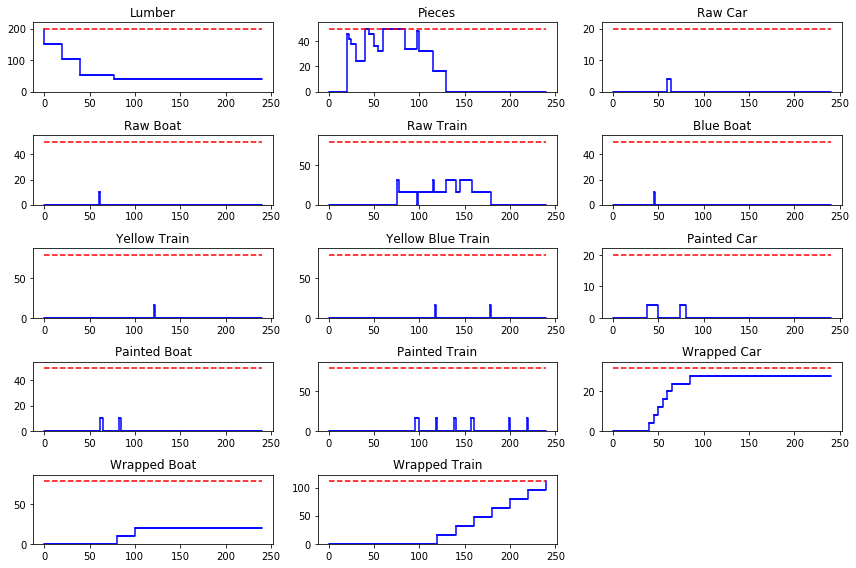

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

### Gant Chart

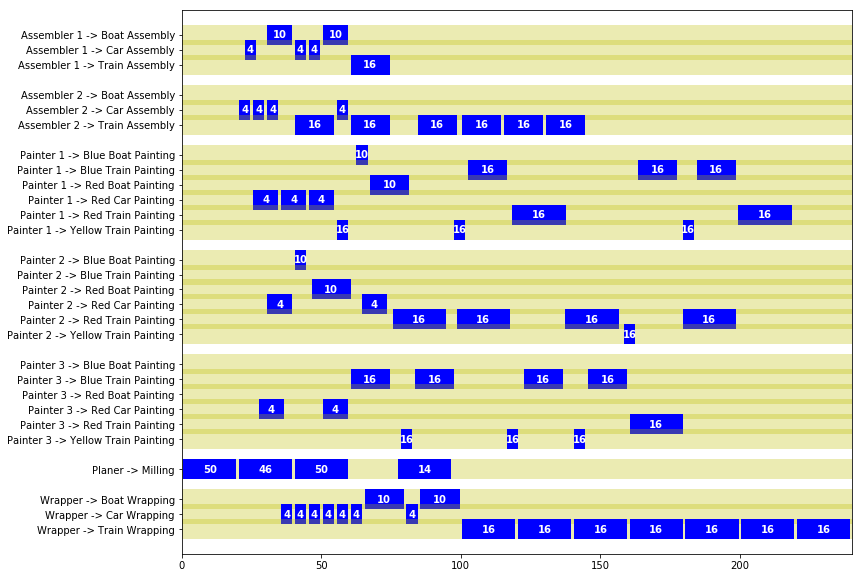

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.0f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

In [108]:
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} oz".format(s,model.S[s,H]()))
print(" ")        
print("Child Happiness Value = {0:12.0f}".format(model.Value()))

Final Conditions
    Final Inventories:
        Lumber        40.0 oz
        Pieces         0.0 oz
        Raw Car        0.0 oz
        Raw Boat       0.0 oz
        Raw Train      0.0 oz
        Blue Boat      0.0 oz
        Yellow Train     0.0 oz
        Yellow Blue Train     0.0 oz
        Painted Car     0.0 oz
        Painted Boat     0.0 oz
        Painted Train     0.0 oz
        Wrapped Car    28.0 oz
        Wrapped Boat    20.0 oz
        Wrapped Train   112.0 oz
 
Child Happiness Value =         2200


With an extra painter elf, the total happiness value increases to 2200, with 7 cars, 2 boats, and 7 trains produced. This yields an increase in child-happpiness value of 40. Therefore, to maximize productivity, assigning one of the extra elves to painting would be beneficial. 

### Assignment of First Elf

#### Assigment as Second Wrapper Elf

In [32]:
H = 240   # total minutes available, 4 hour shift 

Process = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Lumber'           : {'capacity': 200,  'initial': 200, 'value': 0},
        'Pieces'           : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Car'          : {'capacity': 20,   'initial':   0, 'value': 0},
        'Raw Boat'         : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Train'        : {'capacity': 80,   'initial':   0, 'value': 0},
        'Blue Boat'        : {'capacity': 50,   'initial':   0, 'value': 0},
        'Yellow Train'     : {'capacity': 80,   'initial':   0, 'value': 0},
        'Yellow Blue Train': {'capacity': 80,   'initial':   0, 'value': 0},
        'Painted Car'      : {'capacity': 20,   'initial':   0, 'value': 0},
        'Painted Boat'     : {'capacity': 50,   'initial':   0, 'value': 0},
        'Painted Train'    : {'capacity': 80,   'initial':   0, 'value': 0},
        'Wrapped Car'      : {'capacity': 40,   'initial':   0, 'value': 10},
        'Wrapped Boat'     : {'capacity': 100,   'initial':  0, 'value': 12},
        'Wrapped Train'    : {'capacity': 160,   'initial':  0, 'value': 15},      
    },
    'ST_ARCS': {
        ('Lumber',            'Milling')                : {'rho': 1.0},
        ('Pieces',            'Car Assembly')           : {'rho': 1.0},
        ('Pieces',            'Boat Assembly')          : {'rho': 1.0},
        ('Pieces',            'Train Assembly')         : {'rho': 1.0},
        ('Raw Car',           'Red Car Painting')       : {'rho': 1.0},
        ('Raw Boat',          'Blue Boat Painting')     : {'rho': 1.0},
        ('Blue Boat',         'Red Boat Painting')      : {'rho': 1.0},
        ('Raw Train',         'Yellow Train Painting')  : {'rho': 1.0},
        ('Yellow Train',      'Blue Train Painting')    : {'rho': 1.0},
        ('Yellow Blue Train', 'Red Train Painting')     : {'rho': 1.0},
        ('Painted Car',       'Car Wrapping')           : {'rho': 1.0},
        ('Painted Boat',      'Boat Wrapping')          : {'rho': 1.0},
        ('Painted Train',     'Train Wrapping')         : {'rho': 1.0},
    },
    'TS_ARCS': {
        ('Milling',               'Pieces')            : {'dur': 20, 'rho': 1.0},
        ('Car Assembly',          'Raw Car')           : {'dur': 5,  'rho': 1.0},
        ('Boat Assembly',         'Raw Boat')          : {'dur': 10, 'rho': 1.0},
        ('Train Assembly',        'Raw Train')         : {'dur': 15, 'rho': 1.0},
        ('Red Car Painting',      'Painted Car')       : {'dur': 10, 'rho': 1.0},
        ('Red Boat Painting',     'Painted Boat')      : {'dur': 15, 'rho': 1.0},
        ('Red Train Painting',    'Painted Train')     : {'dur': 20, 'rho': 1.0},
        ('Blue Boat Painting',    'Blue Boat')         : {'dur': 5,  'rho': 1.0},
        ('Blue Train Painting',   'Yellow Blue Train') : {'dur': 15, 'rho': 1.0},
        ('Yellow Train Painting', 'Yellow Train')      : {'dur': 5,  'rho': 1.0},
        ('Car Wrapping',          'Wrapped Car')       : {'dur': 5,  'rho': 1.0},
        ('Boat Wrapping',         'Wrapped Boat')      : {'dur': 15, 'rho': 1.0},
        ('Train Wrapping',        'Wrapped Train')     : {'dur': 20, 'rho': 1.0},
    },
    'UNIT_TASKS': {
        ('Planer', 'Milling') : {'Bmin': 0, 'Bmax': 50, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Assembler 1', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
         
        ('Assembler 2', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 1', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 2', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Wrapper 1', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 1', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 1', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},

        ('Wrapper 2', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 2', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 2', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

### Characterization of Tasks

In [33]:
STN = Process

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [34]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

### Characterization of States

In [35]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s

### Characterization of Units

In [36]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [37]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['value']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
# additional production constraints (must produce one of each toy per shift)     
model.cons.add(model.S['Wrapped Car',H] >= 4)
model.cons.add(model.S['Wrapped Boat',H] >= 10)
model.cons.add(model.S['Wrapped Train',H] >= 16)

SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2400.0
  Upper bound: 2400.0
  Number of objectives: 1
  Number of constraints: 22185
  Number of variables: 17114
  Number of nonzeros: 131100
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 751
      Number of created subproblems: 751
  Error rc: 0
  Time: 63.6830039024353
# ----------------------------------------------------------
#   Solution Information
# ---------------------

### State Inventories

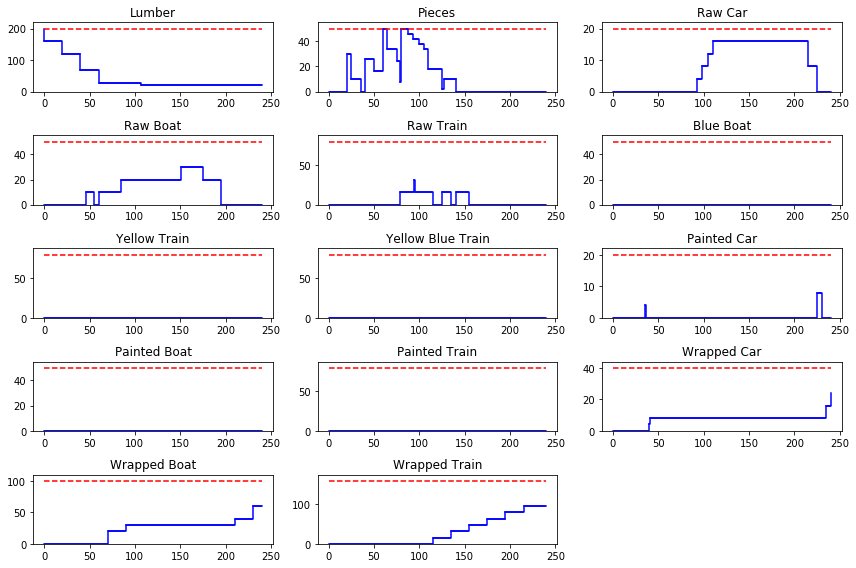

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

### Gant Chart

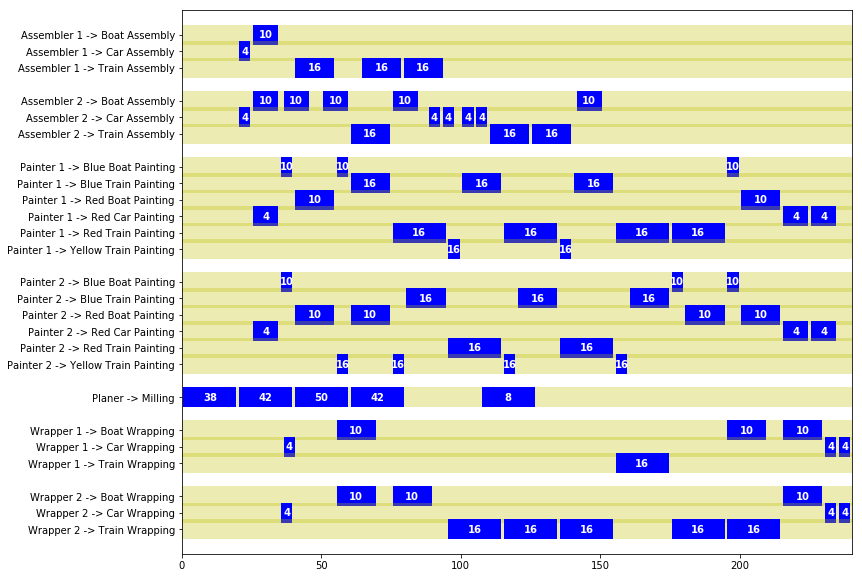

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.0f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

In [40]:
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} oz".format(s,model.S[s,H]()))
print(" ")        
print("Child Happiness Value = {0:12.0f}".format(model.Value()))

Final Conditions
    Final Inventories:
        Lumber        20.0 oz
        Pieces         0.0 oz
        Raw Car        0.0 oz
        Raw Boat       0.0 oz
        Raw Train      0.0 oz
        Blue Boat      0.0 oz
        Yellow Train     0.0 oz
        Yellow Blue Train     0.0 oz
        Painted Car     0.0 oz
        Painted Boat     0.0 oz
        Painted Train     0.0 oz
        Wrapped Car    24.0 oz
        Wrapped Boat    60.0 oz
        Wrapped Train    96.0 oz
 
Child Happiness Value =         2400


With an extra wrapper elf, the total happiness value increases to 2400, with 6 cars, 6 boats, and 6 trains produced. This yields an increase in child-happpiness value of 240. Therefore, to maximize productivity, assigning one of the extra elves to wrapping would be beneficial. 

With this information about the optimization with one extra elf, if Santa wants to maximize productivity with two elves, he should assign one to wrapping a one to painting.

### State-Task Network Data

Third painter elf and second wrapper elf.

In [142]:
H = 240   # total minutes available, 4 hour shift 

Process = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Lumber'           : {'capacity': 200,  'initial': 200, 'value': 0},
        'Pieces'           : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Car'          : {'capacity': 20,   'initial':   0, 'value': 0},
        'Raw Boat'         : {'capacity': 50,   'initial':   0, 'value': 0},
        'Raw Train'        : {'capacity': 80,   'initial':   0, 'value': 0},
        'Blue Boat'        : {'capacity': 50,   'initial':   0, 'value': 0},
        'Yellow Train'     : {'capacity': 80,   'initial':   0, 'value': 0},
        'Yellow Blue Train': {'capacity': 80,   'initial':   0, 'value': 0},
        'Painted Car'      : {'capacity': 20,   'initial':   0, 'value': 0},
        'Painted Boat'     : {'capacity': 50,   'initial':   0, 'value': 0},
        'Painted Train'    : {'capacity': 80,   'initial':   0, 'value': 0},
        'Wrapped Car'      : {'capacity': 28,   'initial':   0, 'value': 10},
        'Wrapped Boat'     : {'capacity': 60,   'initial':  0, 'value': 12},
        'Wrapped Train'    : {'capacity': 112,   'initial':  0, 'value': 15},      
    },
    'ST_ARCS': {
        ('Lumber',            'Milling')                : {'rho': 1.0},
        ('Pieces',            'Car Assembly')           : {'rho': 1.0},
        ('Pieces',            'Boat Assembly')          : {'rho': 1.0},
        ('Pieces',            'Train Assembly')         : {'rho': 1.0},
        ('Raw Car',           'Red Car Painting')       : {'rho': 1.0},
        ('Raw Boat',          'Blue Boat Painting')     : {'rho': 1.0},
        ('Blue Boat',         'Red Boat Painting')      : {'rho': 1.0},
        ('Raw Train',         'Yellow Train Painting')  : {'rho': 1.0},
        ('Yellow Train',      'Blue Train Painting')    : {'rho': 1.0},
        ('Yellow Blue Train', 'Red Train Painting')     : {'rho': 1.0},
        ('Painted Car',       'Car Wrapping')           : {'rho': 1.0},
        ('Painted Boat',      'Boat Wrapping')          : {'rho': 1.0},
        ('Painted Train',     'Train Wrapping')         : {'rho': 1.0},
    },
    'TS_ARCS': {
        ('Milling',               'Pieces')            : {'dur': 20, 'rho': 1.0},
        ('Car Assembly',          'Raw Car')           : {'dur': 5,  'rho': 1.0},
        ('Boat Assembly',         'Raw Boat')          : {'dur': 10, 'rho': 1.0},
        ('Train Assembly',        'Raw Train')         : {'dur': 15, 'rho': 1.0},
        ('Red Car Painting',      'Painted Car')       : {'dur': 10, 'rho': 1.0},
        ('Red Boat Painting',     'Painted Boat')      : {'dur': 15, 'rho': 1.0},
        ('Red Train Painting',    'Painted Train')     : {'dur': 20, 'rho': 1.0},
        ('Blue Boat Painting',    'Blue Boat')         : {'dur': 5,  'rho': 1.0},
        ('Blue Train Painting',   'Yellow Blue Train') : {'dur': 15, 'rho': 1.0},
        ('Yellow Train Painting', 'Yellow Train')      : {'dur': 5,  'rho': 1.0},
        ('Car Wrapping',          'Wrapped Car')       : {'dur': 5,  'rho': 1.0},
        ('Boat Wrapping',         'Wrapped Boat')      : {'dur': 15, 'rho': 1.0},
        ('Train Wrapping',        'Wrapped Train')     : {'dur': 20, 'rho': 1.0},
    },
    'UNIT_TASKS': {
        ('Planer', 'Milling') : {'Bmin': 0, 'Bmax': 50, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Assembler 1', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 1', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
         
        ('Assembler 2', 'Car Assembly')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Boat Assembly') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Assembler 2', 'Train Assembly'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 1', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 1', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Painter 2', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 2', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
     
        ('Painter 3', 'Red Car Painting')     : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Red Boat Painting')    : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Red Train Painting')   : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Blue Boat Painting')   : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Blue Train Painting')  : {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Painter 3', 'Yellow Train Painting'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Wrapper 1', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 1', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 1', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        
        ('Wrapper 2', 'Car Wrapping')  : {'Bmin': 4,  'Bmax':  4,  'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 2', 'Boat Wrapping') : {'Bmin': 10, 'Bmax':  10, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
        ('Wrapper 2', 'Train Wrapping'): {'Bmin': 16, 'Bmax':  16, 'Cost': 0, 'vCost': 0, 'Tclean': 0},
    },
}

### Characterization of Tasks

In [143]:
STN = Process

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [144]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j)

### Characterization of States

In [145]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s

### Characterization of Units

In [146]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [147]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['value']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
# additional production constraints (must produce one of each toy per shift)     
model.cons.add(model.S['Wrapped Car',H] >= 4)
model.cons.add(model.S['Wrapped Boat',H] >= 10)
#model.cons.add(model.S['Wrapped Train',H] >= 16)

SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2680.0
  Upper bound: 2680.0
  Number of objectives: 1
  Number of constraints: 25559
  Number of variables: 20247
  Number of nonzeros: 159414
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 589
      Number of created subproblems: 589
  Error rc: 0
  Time: 73.86876201629639
# ----------------------------------------------------------
#   Solution Information
# --------------------

### State Inventories

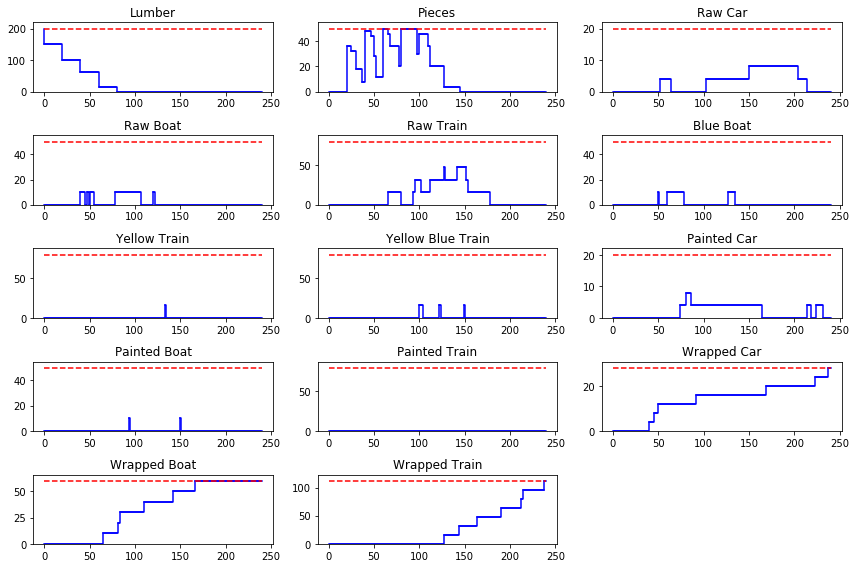

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

plt.figure(figsize=(12,8))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

### Gant Chart

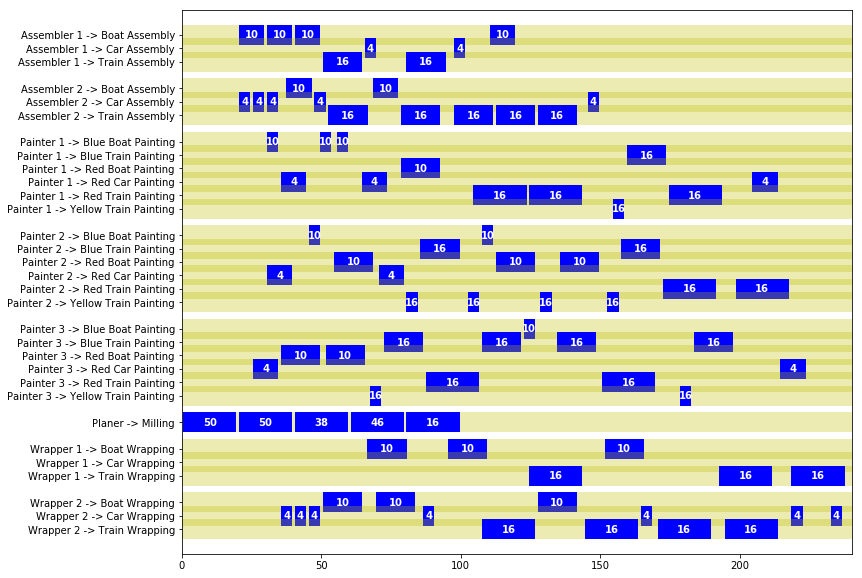

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.0f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

In [150]:
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} oz".format(s,model.S[s,H]()))
print(" ")        
print("Child Happiness Value = {0:12.0f}".format(model.Value()))

Final Conditions
    Final Inventories:
        Lumber         0.0 oz
        Pieces         0.0 oz
        Raw Car        0.0 oz
        Raw Boat       0.0 oz
        Raw Train      0.0 oz
        Blue Boat      0.0 oz
        Yellow Train     0.0 oz
        Yellow Blue Train     0.0 oz
        Painted Car     0.0 oz
        Painted Boat     0.0 oz
        Painted Train     0.0 oz
        Wrapped Car    28.0 oz
        Wrapped Boat    60.0 oz
        Wrapped Train   112.0 oz
 
Child Happiness Value =         2680


With the addition of an extra painter elf and an extra wrapper elf, the total happiness value increases to 2680, with 7 cars, 6 boats, and 7 trains produced. This yields an increase in child-happpiness value of 520. Therefore, these are the optimal elf assignments to maximize productivity. Also, this process increase efficiency because all 200 oz of lumber available for this 4 hour shift is utilized, and there are no raw, partially painted, or unwrapped toys.